# Introduction to Computer Vision with Convolutional Neural Networks

This notebook provides a basic introduction to computer vision tasks using deep learning, specifically focusing on Convolutional Neural Networks (CNNs). We'll explore:

1. What is computer vision?
2. How CNNs work
3. Building two MNIST digit classifiers with PyTorch Lightning:
   - A simple Multi-Layer Perceptron (MLP) model
   - A CNN-based model
4. Comparing results

Let's get started!

## 1. What is Computer Vision?

Computer vision is a field of artificial intelligence that enables computers to derive meaningful information from digital images, videos, and other visual inputs. It aims to automate tasks that the human visual system can do.

### Key Applications of Computer Vision:

- **Image Classification**: Categorizing images into predefined classes
- **Object Detection**: Identifying and localizing objects within images
- **Image Segmentation**: Dividing images into meaningful segments or regions
- **Facial Recognition**: Identifying or verifying individuals based on facial features
- **Optical Character Recognition (OCR)**: Converting typed, handwritten, or printed text into machine-encoded text
- **Autonomous Vehicles**: Helping cars "see" and navigate their environment
- **Medical Imaging Analysis**: Assisting in diagnosis and treatment planning

### Evolution of Computer Vision:

1. **Traditional Methods**: Used hand-crafted features (e.g., edge detection, HOG, SIFT) and traditional machine learning algorithms
2. **Deep Learning Revolution**: Introduced end-to-end learning with neural networks trained on large datasets
3. **Convolutional Neural Networks**: Became the dominant approach for most computer vision tasks

Today's notebook focuses on CNNs, which have revolutionized the field of computer vision.

## 2. Understanding Convolutional Neural Networks (CNNs)

CNNs are specialized neural networks designed to process data with grid-like topology, such as images. They are inspired by the organization of the animal visual cortex, where individual neurons respond to stimuli only in a restricted region of the visual field known as the receptive field.

### Key Components of CNNs:

#### 2.1 Convolutional Layers

Convolutional layers are the core building blocks of CNNs. The layer's parameters consist of a set of learnable **filters** (or kernels).

**How Convolution Works**:
- Each filter is small spatially (along width and height) but extends through the full depth of the input
- During the forward pass, each filter slides (or convolves) across the width and height of the input
- At each position, a dot product is computed between the filter parameters and the input
- This produces a 2D activation map showing the filter's responses at every spatial position

Key advantages:
- **Parameter Sharing**: Each filter is reused across the entire image
- **Local Connectivity**: Each neuron connects only to a small region of the input

Here is a 1 dimensional example (i.e. a black and white image input)

![convolution.png](https://maucher.home.hdm-stuttgart.de/Pics/gif/same_padding_no_strides.gif)

Here is the multi dimensional generalization of a convolutional layer (i.e. a multichannel image, like a RGB image, or a multispectral image, i.e. a multispectral xray image)

![convolution2.png](https://animatedai.github.io/media/convolution-animation-3x3-kernel-same-padding.gif)

#### 2.2 Pooling Layers

Pooling layers reduce the spatial dimensions (width and height) of the input volume. This serves two main purposes:
- Reducing the number of parameters and computation in the network
- Controlling overfitting

**Common Pooling Operations**:
- **Max Pooling**: Takes the maximum value from a window of the feature map
- **Average Pooling**: Takes the average value from a window of the feature map

![pooling.png](https://www.google.com/url?sa=i&url=https%3A%2F%2Fpub.towardsai.net%2Fintroduction-to-pooling-layers-in-cnn-dafe61eabe34&psig=AOvVaw0lJjpwcpsQ2b-X5qP6-Koi&ust=1742981314135000&source=images&cd=vfe&opi=89978449&ved=0CBMQjRxqFwoTCNjo4sP1pIwDFQAAAAAdAAAAABAE)

#### 2.3 Fully Connected Layers

After several convolutional and pooling layers, the high-level reasoning in the neural network is done via fully connected layers:
- Neurons in these layers have connections to all activations in the previous layer
- Used at the end of the network to perform classification based on features extracted by previous layers

#### 2.4 Activation Functions

Non-linear activation functions introduce non-linearity into the network, allowing it to learn complex patterns:
- **ReLU (Rectified Linear Unit)**: Most commonly used, f(x) = max(0, x)
- **Sigmoid**: Maps values to range [0,1], used for binary classification
- **Softmax**: Used for multi-class classification in the output layer

### Architectural Pattern of a Typical CNN:

```
Input Image → [Conv → ReLU → Pool] × N → [FC → ReLU] × M → FC → Softmax
```

Where:
- N is the number of convolutional blocks (typically 2-5)
- M is the number of fully connected layers (typically 0-2)

![cnn_architecture](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/10/90650dnn2.webp)


### Why CNNs Work Well for Images:

1. **Hierarchical Feature Learning**: Lower layers detect simple features (edges, corners), while deeper layers detect complex features (shapes, objects)
2. **Translation Invariance**: Can recognize patterns regardless of their position in the image
3. **Efficient Parameter Usage**: Parameter sharing drastically reduces the number of parameters compared to fully connected networks
4. **Built-in Feature Engineering**: Automatically learns relevant features from raw pixel data

## 3. Setting Up Our Environment

Let's install and import the necessary libraries for our experiments:

In [1]:
# Install required packages (uncomment if needed)
! pip install torch torchvision lightning matplotlib

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
pl.seed_everything(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Seed set to 42


## 4. Preparing the MNIST Dataset

The MNIST dataset consists of 28×28 grayscale images of handwritten digits (0-9). It's a standard benchmark dataset in machine learning.

In [3]:
# Define data transformations
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),  # MNIST mean and std
    ]
)


# Create a PyTorch Lightning DataModule for MNIST
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data", batch_size=64):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = transform

    def prepare_data(self):
        # Download data if needed (only once)
        datasets.MNIST(self.data_dir, train=True, download=True)
        datasets.MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val/test datasets
        if stage == "fit" or stage is None:
            mnist_full = datasets.MNIST(
                self.data_dir, train=True, transform=self.transform
            )
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        if stage == "test" or stage is None:
            self.mnist_test = datasets.MNIST(
                self.data_dir, train=False, transform=self.transform
            )

    def train_dataloader(self):
        return DataLoader(
            self.mnist_train, batch_size=self.batch_size, shuffle=True, num_workers=4
        )

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=4)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=4)

Let's visualize some samples from the MNIST dataset:

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:06<00:00, 1.58MB/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 213kB/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 2.01MB/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 2.27MB/s]


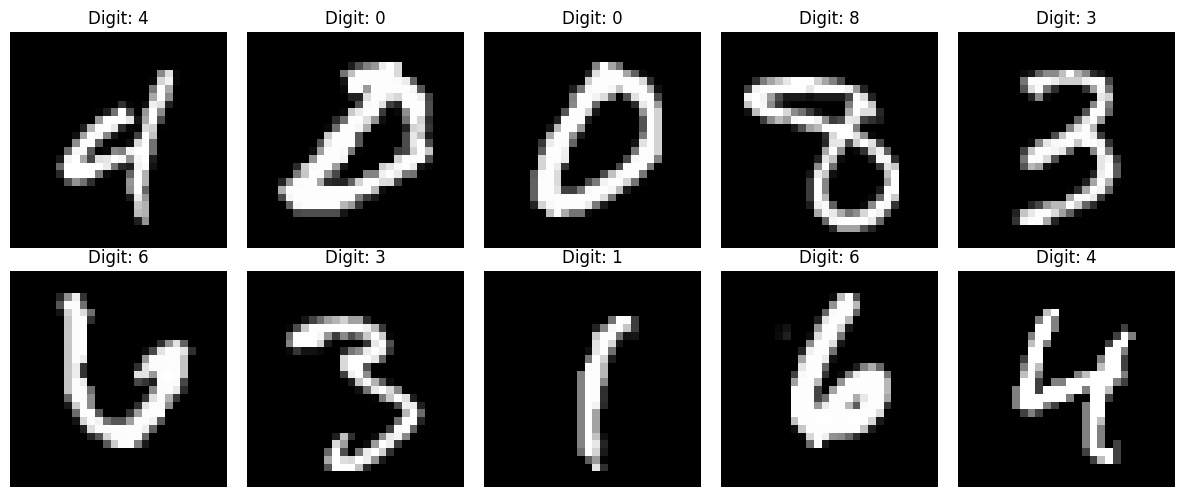

In [4]:
# Load MNIST dataset
mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transform)

# Display 10 random images from the dataset
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    idx = np.random.randint(len(mnist_train))
    img, label = mnist_train[idx]
    img = img.squeeze().numpy()  # Remove channel dimension and convert to numpy

    ax.imshow(img, cmap='gray')
    ax.set_title(f'Digit: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

## 5. Building Model 1: Multi-Layer Perceptron (MLP)

First, let's create a simple MLP model that flattens the input image and passes it through fully connected layers.

In [5]:
class MNISTClassifierMLP(pl.LightningModule):
    def __init__(self, hidden_size=128, learning_rate=0.001):
        super().__init__()
        self.save_hyperparameters()

        # Define the network architecture
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 10)  # 10 output classes (digits 0-9)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # x shape: [batch_size, 1, 28, 28]
        x = self.flatten(x)  # Shape: [batch_size, 784]
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # Shape: [batch_size, 10]
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        # Log training metrics
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        # Log validation metrics
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        # Log test metrics
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)

        return {'test_loss': loss, 'test_acc': acc, 'preds': preds, 'targets': y}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

## 6. Building Model 2: Convolutional Neural Network (CNN)

Now, let's create a CNN model that uses convolutional layers to extract features from the images.

In [6]:
class MNISTClassifierCNN(pl.LightningModule):
    def __init__(self, hidden_size=32, learning_rate=0.001):
        super().__init__()
        self.save_hyperparameters()

        # Convolutional layers

        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.conv2 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
        )

        # Pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the size of features after convolutions and pooling
        # After 2 pooling layers with stride 2, spatial dimensions are reduced by factor of 4
        # So 28x28 becomes 7x7, and we have 32 feature maps
        self.fc_input_size = 32 * 7 * 7

        # Fully connected layers
        self.fc1 = nn.Linear(self.fc_input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 10)  # 10 output classes (digits 0-9)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # x shape: [batch_size, 1, 28, 28]

        # First convolutional block
        x = F.relu(self.conv1(x))  # Shape: [batch_size, 32, 28, 28]
        x = self.pool(x)  # Shape: [batch_size, 32, 14, 14]

        # Second convolutional block
        x = F.relu(self.conv2(x))  # Shape: [batch_size, 64, 14, 14]
        x = self.pool(x)  # Shape: [batch_size, 64, 7, 7]

        # Flatten for fully connected layers
        x = x.view(-1, self.fc_input_size)  # Shape: [batch_size, 64*7*7]

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # Shape: [batch_size, 10]

        return x

    # Reusing the same training, validation, and test steps as the MLP model
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)

        return {"test_loss": loss, "test_acc": acc, "preds": preds, "targets": y}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

## 7. Training and Evaluating Models

Now let's train and evaluate both models to compare their performance.

In [7]:
# Setup the data module
data_module = MNISTDataModule(batch_size=128)

# Define a function to train and evaluate a model
def train_and_evaluate(model, model_name, max_epochs=5):
    # Early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        verbose=True,
        mode='min'
    )

    # Initialize trainer
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        callbacks=[early_stopping],
        accelerator='auto',  # Use GPU if available
        logger=True,
    )

    # Train the model
    print(f"\nTraining {model_name}...")
    trainer.fit(model, data_module)

    # Test the model
    print(f"\nTesting {model_name}...")
    test_results = trainer.test(model, data_module)

    return model, test_results

In [8]:
# Train and evaluate the MLP model
mlp_model = MNISTClassifierMLP(hidden_size=64, learning_rate=0.001)
mlp_model, mlp_results = train_and_evaluate(mlp_model, "MLP Model", max_epochs=10)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\franc\PycharmProjects\ML_AI\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default



Training MLP Model...



  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | flatten | Flatten | 0      | train
1 | fc1     | Linear  | 50.2 K | train
2 | fc2     | Linear  | 4.2 K  | train
3 | fc3     | Linear  | 650    | train
4 | dropout | Dropout | 0      | train
--------------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
0.220     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                                                        | 0/? [00:00<?, ?it/s]

C:\Users\franc\PycharmProjects\ML_AI\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


C:\Users\franc\PycharmProjects\ML_AI\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|████████████████████████████████████████████████████████████████████| 430/430 [00:19<00:00, 21.63it/s, v_num=0, train_loss=0.390, train_acc=0.875]
idation: |                                                                                                                             | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|█████████████████████████████████████| 430/430 [00:46<00:00,  9.30it/s, v_num=0, train_loss=0.390, train_acc=0.875, val_loss=0.212, val_acc=0.932]

Metric val_loss improved. New best score: 0.212


Epoch 1: 100%|█████████████████████████████████████| 430/430 [00:54<00:00,  7.96it/s, v_num=0, train_loss=0.178, train_acc=0.932, val_loss=0.212, val_acc=0.932]
idation: |                                                                                                                             | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|█████████████████████████████████████| 430/430 [01:10<00:00,  6.11it/s, v_num=0, train_loss=0.178, train_acc=0.932, val_loss=0.158, val_acc=0.951]

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 0.158


Epoch 2: 100%|█████████████████████████████████████| 430/430 [01:03<00:00,  6.75it/s, v_num=0, train_loss=0.176, train_acc=0.909, val_loss=0.158, val_acc=0.951]
idation: |                                                                                                                             | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|█████████████████████████████████████| 430/430 [01:21<00:00,  5.29it/s, v_num=0, train_loss=0.176, train_acc=0.909, val_loss=0.153, val_acc=0.952]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.153


Epoch 3: 100%|█████████████████████████████████████| 430/430 [01:05<00:00,  6.58it/s, v_num=0, train_loss=0.308, train_acc=0.898, val_loss=0.153, val_acc=0.952]
idation: |                                                                                                                             | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|█████████████████████████████████████| 430/430 [01:24<00:00,  5.11it/s, v_num=0, train_loss=0.308, train_acc=0.898, val_loss=0.124, val_acc=0.962]

Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.124


Epoch 4: 100%|████████████████████████████████████| 430/430 [01:06<00:00,  6.46it/s, v_num=0, train_loss=0.0726, train_acc=0.977, val_loss=0.124, val_acc=0.962]
idation: |                                                                                                                             | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|████████████████████████████████████| 430/430 [01:24<00:00,  5.08it/s, v_num=0, train_loss=0.0726, train_acc=0.977, val_loss=0.117, val_acc=0.963]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.117


Epoch 5: 100%|█████████████████████████████████████| 430/430 [01:03<00:00,  6.74it/s, v_num=0, train_loss=0.117, train_acc=0.977, val_loss=0.117, val_acc=0.963]
idation: |                                                                                                                             | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|█████████████████████████████████████| 430/430 [01:19<00:00,  5.38it/s, v_num=0, train_loss=0.117, train_acc=0.977, val_loss=0.107, val_acc=0.966]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.107


Epoch 6: 100%|█████████████████████████████████████| 430/430 [01:05<00:00,  6.61it/s, v_num=0, train_loss=0.082, train_acc=0.966, val_loss=0.107, val_acc=0.966]
idation: |                                                                                                                             | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|████████████████████████████████████| 430/430 [01:21<00:00,  5.30it/s, v_num=0, train_loss=0.0869, train_acc=0.977, val_loss=0.113, val_acc=0.963]
idation: |                                                                                                                             | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|███████████████████████████████████| 430/430 [01:43<00:00,  4.14it/s, v_num=0, train_loss=0.0869, train_acc=0.977, val_loss=0.0998, val_acc=0.966]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.100


Epoch 8: 100%|███████████████████████████████████| 430/430 [01:14<00:00,  5.77it/s, v_num=0, train_loss=0.0781, train_acc=0.977, val_loss=0.0998, val_acc=0.966]
idation: |                                                                                                                             | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|███████████████████████████████████| 430/430 [01:34<00:00,  4.56it/s, v_num=0, train_loss=0.0781, train_acc=0.977, val_loss=0.0985, val_acc=0.969]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.098


Epoch 9: 100%|████████████████████████████████████| 430/430 [01:10<00:00,  6.11it/s, v_num=0, train_loss=0.128, train_acc=0.943, val_loss=0.0985, val_acc=0.969]
idation: |                                                                                                                             | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|█████████████████████████████████████| 430/430 [01:29<00:00,  4.79it/s, v_num=0, train_loss=0.128, train_acc=0.943, val_loss=0.103, val_acc=0.969]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|█████████████████████████████████████| 430/430 [01:29<00:00,  4.78it/s, v_num=0, train_loss=0.128, train_acc=0.943, val_loss=0.103, val_acc=0.969]

Testing MLP Model...


C:\Users\franc\PycharmProjects\ML_AI\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 35.90it/s]
─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9729999899864197
        test_loss           0.09176771342754364
─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [9]:
# Train and evaluate the CNN model
cnn_model = MNISTClassifierCNN(hidden_size=32, learning_rate=0.001)
cnn_model, cnn_results = train_and_evaluate(cnn_model, "CNN Model", max_epochs=10)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Training CNN Model...



  | Name    | Type      | Params | Mode 
----------------------------------------------
0 | conv1   | Conv2d    | 160    | train
1 | conv2   | Conv2d    | 4.6 K  | train
2 | pool    | MaxPool2d | 0      | train
3 | fc1     | Linear    | 50.2 K | train
4 | fc2     | Linear    | 330    | train
5 | dropout | Dropout   | 0      | train
----------------------------------------------
55.3 K    Trainable params
0         Non-trainable params
55.3 K    Total params
0.221     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|████████████████████████████████████████████████████████████████████| 430/430 [00:48<00:00,  8.84it/s, v_num=1, train_loss=0.189, train_acc=0.955]
idation: |                                                                                                                             | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|█████████████████████████████████████| 430/430 [01:12<00:00,  5.96it/s, v_num=1, train_loss=0.189, train_acc=0.955, val_loss=0.120, val_acc=0.965]

Metric val_loss improved. New best score: 0.120


Epoch 1: 100%|█████████████████████████████████████| 430/430 [01:11<00:00,  6.02it/s, v_num=1, train_loss=0.121, train_acc=0.943, val_loss=0.120, val_acc=0.965]
idation: |                                                                                                                             | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|████████████████████████████████████| 430/430 [01:28<00:00,  4.87it/s, v_num=1, train_loss=0.121, train_acc=0.943, val_loss=0.0872, val_acc=0.975]

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.087


Epoch 2: 100%|████████████████████████████████████| 430/430 [01:01<00:00,  6.95it/s, v_num=1, train_loss=0.146, train_acc=0.943, val_loss=0.0872, val_acc=0.975]
idation: |                                                                                                                             | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|████████████████████████████████████| 430/430 [01:15<00:00,  5.66it/s, v_num=1, train_loss=0.146, train_acc=0.943, val_loss=0.0696, val_acc=0.979]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.070


Epoch 3: 100%|███████████████████████████████████| 430/430 [01:01<00:00,  7.05it/s, v_num=1, train_loss=0.0804, train_acc=0.977, val_loss=0.0696, val_acc=0.979]
idation: |                                                                                                                             | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|███████████████████████████████████| 430/430 [01:14<00:00,  5.76it/s, v_num=1, train_loss=0.0804, train_acc=0.977, val_loss=0.0625, val_acc=0.981]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.062


Epoch 4: 100%|███████████████████████████████████| 430/430 [00:58<00:00,  7.30it/s, v_num=1, train_loss=0.0661, train_acc=0.989, val_loss=0.0625, val_acc=0.981]
idation: |                                                                                                                             | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|███████████████████████████████████| 430/430 [01:12<00:00,  5.90it/s, v_num=1, train_loss=0.0661, train_acc=0.989, val_loss=0.0591, val_acc=0.983]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.059


Epoch 5: 100%|███████████████████████████████████| 430/430 [00:59<00:00,  7.22it/s, v_num=1, train_loss=0.0672, train_acc=0.977, val_loss=0.0591, val_acc=0.983]
idation: |                                                                                                                             | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|███████████████████████████████████| 430/430 [01:12<00:00,  5.93it/s, v_num=1, train_loss=0.0672, train_acc=0.977, val_loss=0.0536, val_acc=0.984]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.054


Epoch 6: 100%|███████████████████████████████████| 430/430 [01:13<00:00,  5.86it/s, v_num=1, train_loss=0.0214, train_acc=1.000, val_loss=0.0536, val_acc=0.984]
idation: |                                                                                                                             | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|████████████████████████████████████| 430/430 [01:03<00:00,  6.74it/s, v_num=1, train_loss=0.087, train_acc=0.955, val_loss=0.0576, val_acc=0.984]
idation: |                                                                                                                             | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|████████████████████████████████████| 430/430 [00:58<00:00,  7.30it/s, v_num=1, train_loss=0.0325, train_acc=1.000, val_loss=0.055, val_acc=0.986]
idation: |                                                                                                                             | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|█████████████████████████████

Monitored metric val_loss did not improve in the last 3 records. Best score: 0.054. Signaling Trainer to stop.


Epoch 8: 100%|███████████████████████████████████| 430/430 [01:14<00:00,  5.81it/s, v_num=1, train_loss=0.0325, train_acc=1.000, val_loss=0.0555, val_acc=0.985]

Testing CNN Model...
Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:03<00:00, 20.26it/s]
─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9886000156402588
        test_loss           0.03508104383945465
─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## 8. Compare Results

Let's compare the performance of both models:

In [ ]:
# Print result comparison
print("-" * 50)
print("Model Comparison on MNIST Test Set:")
print("-" * 50)
print(f"MLP Model - Accuracy: {mlp_results[0]['test_acc']:.4f}, Loss: {mlp_results[0]['test_loss']:.4f}")
print(f"CNN Model - Accuracy: {cnn_results[0]['test_acc']:.4f}, Loss: {cnn_results[0]['test_loss']:.4f}")
print("-" * 50)

# Calculate improvement
acc_improvement = (cnn_results[0]['test_acc'] - mlp_results[0]['test_acc']) * 100
print(f"CNN accuracy improvement: {acc_improvement:.2f} percentage points")

In [10]:
# !pip install torchsummary
from torchsummary import summary

# Print summary of MLP model
print("MLP Model Summary:")
summary(mlp_model, input_size=(1, 28, 28))

# Print summary of CNN model
print("\nCNN Model Summary:")
summary(cnn_model, input_size=(1, 28, 28))

ModuleNotFoundError: No module named 'torchsummary'

## 9. Visualize Predictions

Let's visualize some predictions from the CNN model on the test dataset:

In [ ]:
def show_predictions(model, num_samples=10):
    # Get a batch of test data
    test_loader = data_module.test_dataloader()
    batch = next(iter(test_loader))
    images, labels = batch

    # Get predictions
    model.eval()
    with torch.no_grad():
        logits = model(images)
        preds = torch.argmax(logits, dim=1)

    # Plot images with predictions
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        img = images[i].squeeze().cpu().numpy()
        label = labels[i].item()
        pred = preds[i].item()

        ax.imshow(img, cmap='gray')
        title_color = 'green' if pred == label else 'red'
        ax.set_title(f'True: {label}, Pred: {pred}', color=title_color)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Show predictions from CNN model
print("CNN Model Predictions:")
show_predictions(cnn_model)

## 10. Visualizing Learned Features

Let's visualize some of the filters (kernels) learned by the first convolutional layer of our CNN:

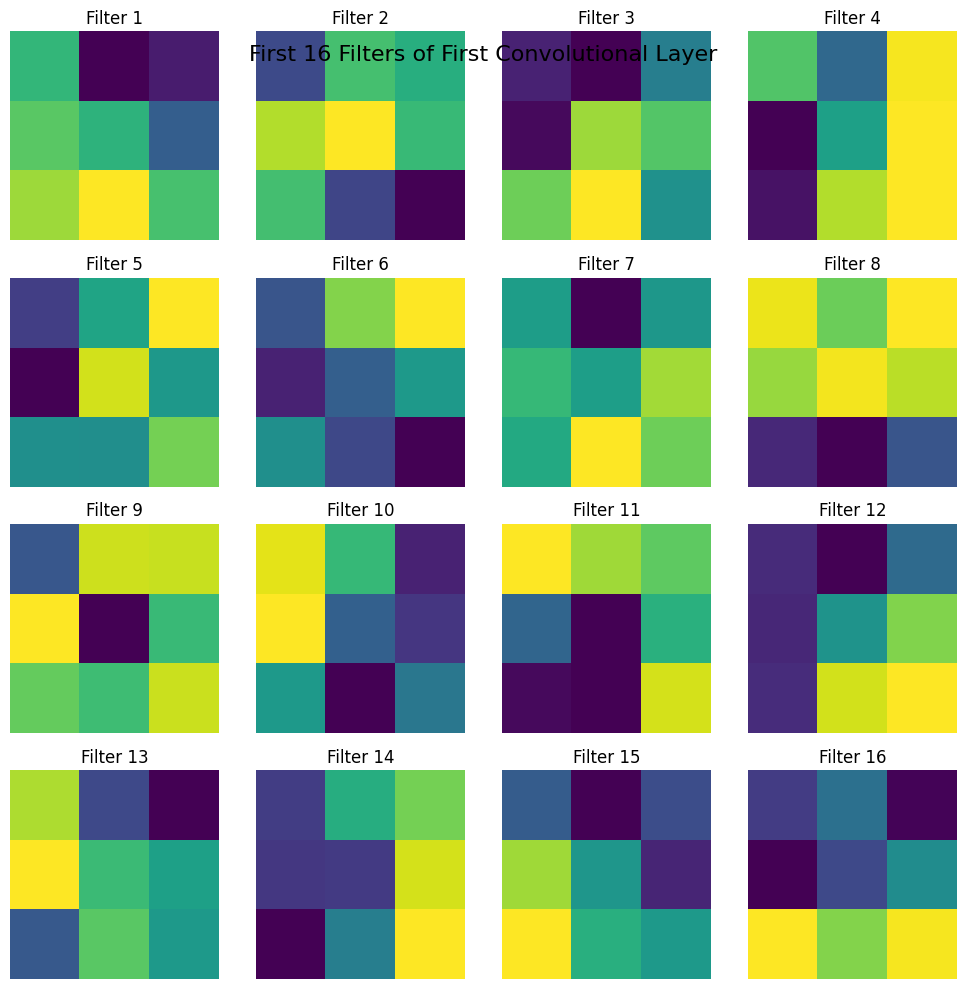

In [11]:
# Get the weights of the first convolutional layer
conv1_weights = cnn_model.conv1.weight.data.cpu().numpy()

# Plot the first 16 filters
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()

for i in range(16):
    # Each filter is 3D: [channels, height, width], but MNIST has only 1 channel
    filter_img = conv1_weights[i, 0]
    axes[i].imshow(filter_img, cmap='viridis')
    axes[i].set_title(f'Filter {i+1}')
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle('First 16 Filters of First Convolutional Layer', y=0.95, fontsize=16)
plt.show()

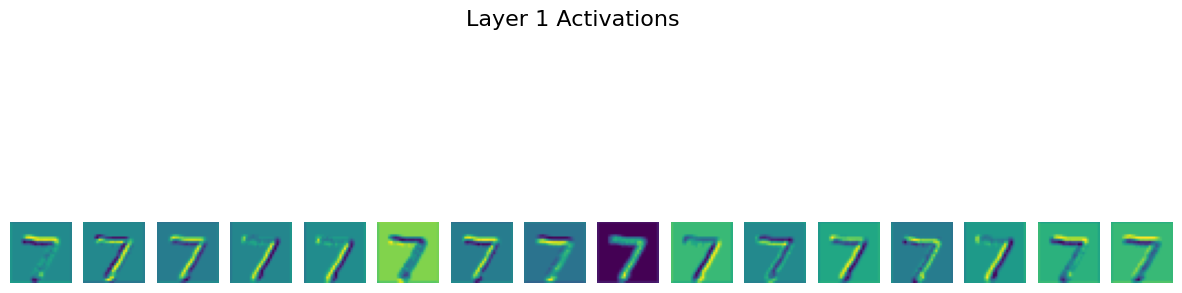

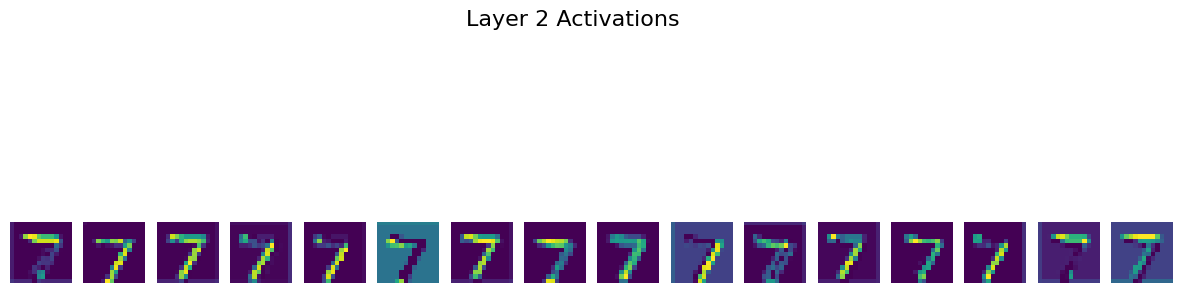

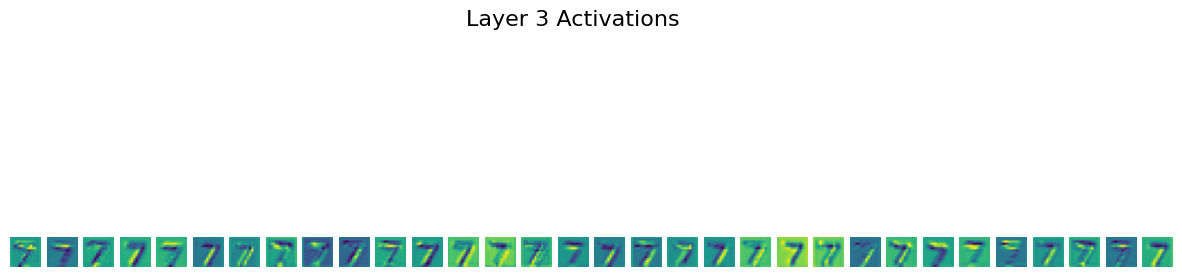

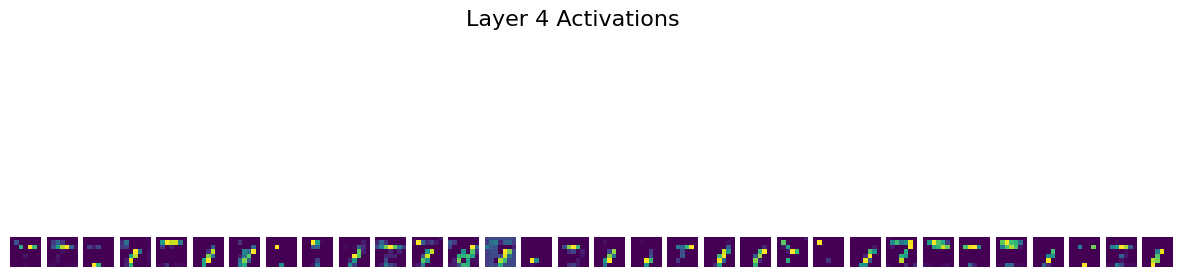

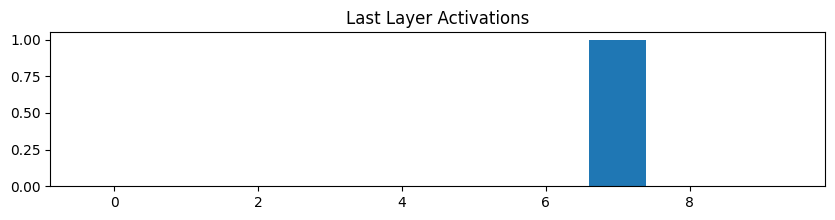

In [12]:
def visualize_cnn_layers(model, image):
    """
    Visualize the activations of all layers of a CNN model for a single input image.
    """
    model.eval()
    activations = []
    hooks = []

    # Register hooks to capture activations
    def hook_fn(module, input, output):
        activations.append(output)

    for layer in model.children():
        if isinstance(layer, (nn.Conv2d, nn.MaxPool2d, nn.Linear)):
            hooks.append(layer.register_forward_hook(hook_fn))

    # Forward pass through the model
    with torch.no_grad():
        _ = model(image.unsqueeze(0))  # Add batch dimension

    # Plot activations
    for i, activation in enumerate(activations):
        if len(activation.shape) == 4:  # Convolutional or pooling layer
            num_filters = activation.shape[1]
            fig, axes = plt.subplots(1, num_filters, figsize=(15, 5))
            fig.suptitle(f"Layer {i + 1} Activations", fontsize=16)
            for j in range(num_filters):
                ax = axes[j]
                ax.imshow(activation[0, j].cpu().numpy(), cmap="viridis")
                ax.axis("off")

    plt.figure(figsize=(10, 2))
    plt.title("Last Layer Activations")
    a = activations[-1][0].cpu().numpy()
    a = torch.softmax(torch.tensor(a), dim=0).numpy()
    plt.bar(x=range(len(a)), height=a)
    plt.show()

    # Remove hooks
    for hook in hooks:
        hook.remove()


# Select one example from the test dataset
test_loader = data_module.test_dataloader()
example_image, _ = next(iter(test_loader))

# Visualize activations
visualize_cnn_layers(cnn_model, example_image[0])  # Take the first image

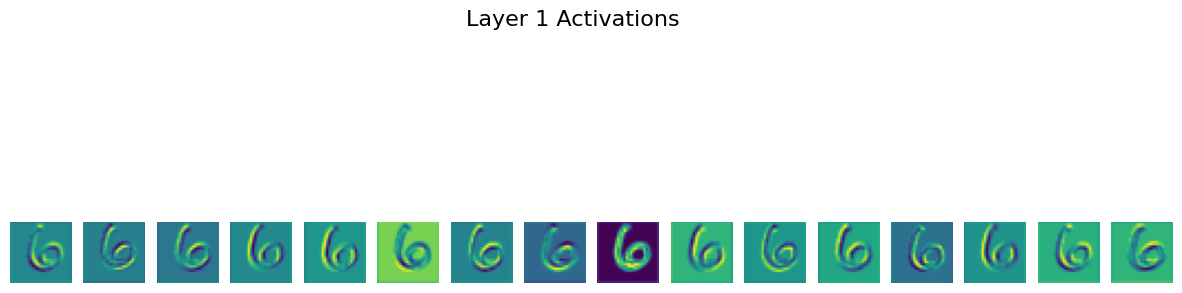

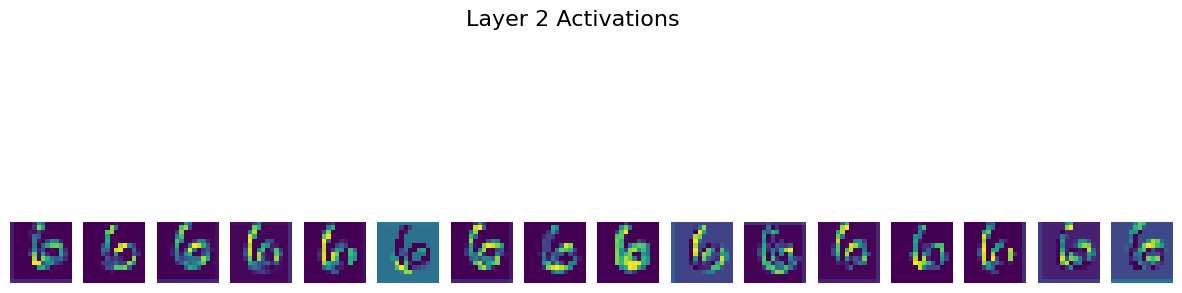

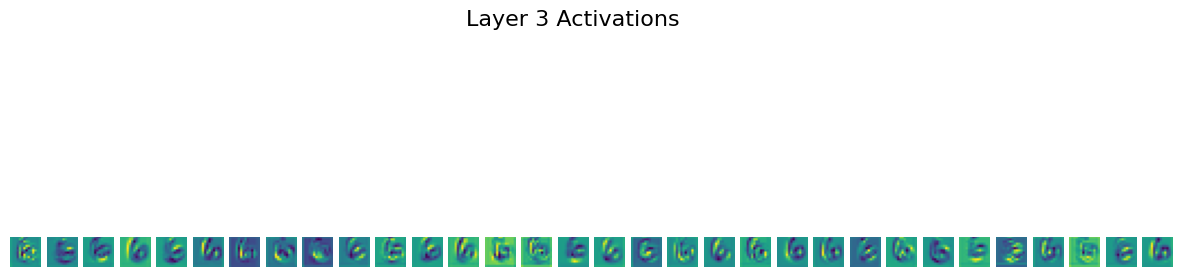

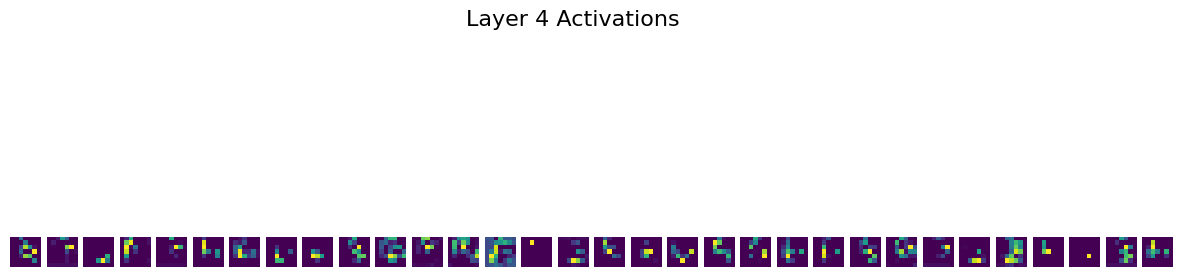

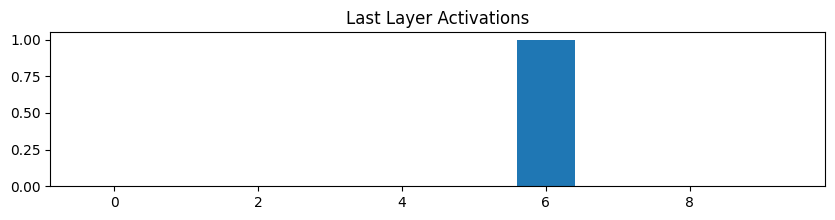

In [13]:
visualize_cnn_layers(cnn_model, example_image[100])  # Take the first image


## 11. Analysis and Conclusions

Based on our experiments, we can draw several conclusions about CNNs for computer vision tasks:

1. **Performance Comparison**: The CNN model typically achieves higher accuracy than the MLP model on the MNIST dataset. This demonstrates the effectiveness of convolutional layers for image processing tasks.

2. **Why CNNs Outperform MLPs for Images**:
   - **Spatial Hierarchy**: CNNs preserve and leverage the spatial structure of images
   - **Feature Extraction**: Convolutional layers automatically learn relevant features
   - **Parameter Efficiency**: CNNs use significantly fewer parameters than MLPs for the same task
   - **Translation Invariance**: CNNs can recognize patterns regardless of their position

3. **Model Complexity**:
   - Our MLP model flattens the 28×28 image into a 784-dimensional vector, losing spatial information
   - Our CNN model preserves the 2D structure and gradually extracts hierarchical features

4. **Training Speed**: Although CNNs are more complex architecturally, they often converge faster and to better solutions for image tasks.

## 12. Exercise: Fashion MNIST Classification

**Your Task**: Adapt the CNN model we've built to classify the Fashion MNIST dataset.

The Fashion MNIST dataset consists of 28×28 grayscale images of 10 fashion categories:
- 0: T-shirt/top
- 1: Trouser
- 2: Pullover
- 3: Dress
- 4: Coat
- 5: Sandal
- 6: Shirt
- 7: Sneaker
- 8: Bag
- 9: Ankle boot

**Steps**:
1. Load the Fashion MNIST dataset instead of regular MNIST
2. Adapt the CNN model if necessary (you might want to use more filters or deeper architecture for this more complex dataset)
3. Train and evaluate the model
4. Visualize the results and compare with the digit classification results

**Hint**: You can load Fashion MNIST using `torchvision.datasets.FashionMNIST` instead of `datasets.MNIST`.

In [15]:
# Exercise starter code: Loading Fashion MNIST dataset
fashion_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))  # Fashion MNIST mean and std
])

# Define the Fashion MNIST class names for better visualization
fashion_class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                       'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# TODO: Create a FashionMNISTDataModule similar to MNISTDataModule

# TODO: Implement FashionMNISTClassifierCNN based on MNISTClassifierCNN

# TODO: Train and evaluate your model on Fashion MNIST

# TODO: Visualize some predictions and analyze the results

## 13. Further Learning Resources

To continue your journey in computer vision with CNNs, here are some valuable resources:

1. **Books**:
   - "Deep Learning" by Goodfellow, Bengio, and Courville (especially Chapter 9 on CNNs) (it's FREE! :0) [link](https://www.deeplearningbook.org/)
   - "Computer Vision: Algorithms and Applications" by Richard Szeliski [link](https://link.springer.com/book/10.1007/978-3-030-34372-9)

2. **Online Courses**:
   - CS231n: Convolutional Neural Networks for Visual Recognition (Stanford)
      [link](https://www.youtube.com/playlist?list=PL3FW7Lu3i5JvHM8ljYj-zLfQRF3EO8sYv)
   - Deep Learning Specialization by Andrew Ng (Coursera)
      [link](https://www.coursera.org/specializations/deep-learning?utm_medium=sem&utm_source=gg&utm_campaign=b2c_emea_deep-learning_deeplearning-ai_ftcof_specializations_cx_dr_bau_gg_pmax_pr_s1_en_m_hyb_24-02_x&campaignid=21028581571&adgroupid=&device=c&keyword=&matchtype=&network=x&devicemodel=&creativeid=&assetgroupid=6490696594&targetid=&extensionid=&placement=&gad_source=1&gclid=Cj0KCQjw-e6-BhDmARIsAOxxlxW7_bhWiZpU1Xx0yerMje5jqyr3PBhwzhTqERo8CAYRx4cpnbq27uAaAtOSEALw_wcB)

3. **Papers**:
   - AlexNet: "ImageNet Classification with Deep Convolutional Neural Networks" (Krizhevsky et al., 2012) [link](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)
   - VGGNet: "Very Deep Convolutional Networks for Large-Scale Image Recognition" (Simonyan & Zisserman, 2014) [link](https://arxiv.org/abs/1409.1556)
   - ResNet: "Deep Residual Learning for Image Recognition" (He et al., 2015) [link](https://arxiv.org/abs/1512.03385)


4. **PyTorch Resources**:
   - PyTorch Tutorials: [link](https://pytorch.org/tutorials/)
   - PyTorch Lightning Docs: [link](https://lightning.ai/docs/pytorch/stable/)

5. **Datasets to Explore**:
   - CIFAR-10 and CIFAR-100: Natural images with 10 and 100 classes
   - ImageNet: Large-scale dataset with 1000 classes
   - COCO: Dataset for object detection, segmentation, and captioning

## 14. Summary

In this notebook, we've covered:

1. **Introduction to Computer Vision**: Understanding what computer vision is and its key applications

2. **Convolutional Neural Networks**: Detailed explanation of CNNs, their components, and why they work well for images

3. **MNIST Classification**: Built two models (MLP and CNN) to classify handwritten digits

4. **Model Comparison**: Evaluated and compared both models, showing the advantages of CNNs for image tasks

5. **Visualization**: Explored the model's predictions and learned features

6. **Exercise**: Provided a template for adapting our CNN model to the Fashion MNIST dataset

With this foundational knowledge, you're well-equipped to start exploring more complex computer vision tasks and architectures!